# 介绍

泰坦尼克号（英语：RMS Titanic）是一艘奥林匹克级邮轮，于1912年4月首航时撞上冰山后沉没。泰坦尼克号是同级的3艘超级邮轮中的第2艘，与姐妹船奥林匹克号和不列颠号为白星航运公司的乘客们提供大西洋旅行。

泰坦尼克号由位于北爱尔兰贝尔法斯特的哈兰·沃尔夫船厂兴建，是当时最大的客运轮船，由于其规模相当一艘现代航空母舰，因而号称“上帝也沉没不了的巨型邮轮”。在泰坦尼克号的首航中，从英国南安普敦出发，途经法国瑟堡-奥克特维尔以及爱尔兰昆士敦，计划横渡大西洋前往美国纽约市。但因为人为错误，于1912年4月14日船上时间夜里11点40分撞上冰山；2小时40分钟后，即4月15日凌晨02点20分，船裂成两半后沉入大西洋，死亡人数超越1500人，堪称20世纪最大的海难事件，同时也是最广为人知的海难之一。

本次分析的数据是泰坦尼克号事故的样本数据。

----
# 加载csv数据

In [119]:
import pandas as pd
import numpy as np

titanic_df = pd.read_csv('./titanic-data.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 数据处理

## 是否存在缺失字段

In [120]:
titanic_df.isna().sum()/titanic_df.isna().count()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

## 删除唔关字段
由于Name，Ticket与是否生还没有太大关系，故选择删除，另外仓位其实与是否生还有一定联系，但是从上面统计得知仓位缺失值超过半数，达到77.1%，缺失比例太高，已经没有太大分析意义，故也把该值删除。

In [121]:
# 删除Name，Ticket，Cabin，这些数据和生还率好像都没有什么关系，而且Cabin这个字段还记录不全
# Ticket这个字段对分析毫无作用
del titanic_df['Name']
del titanic_df['Ticket']
del titanic_df['Cabin']
titanic_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


## 检查是否存在空值

In [122]:
titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64

经过统计，观察到Age存在空值，Embarked存在空值，先把Embarked空值的数据打印出来看看是什么数据

In [123]:
# 对登船记录做填充，因为登船记录只有两个数据缺失，所以直接补充为Unknown即可，这两个数据对分析关系不是很大
titanic_df.Embarked.fillna("Unknown", inplace=True)

In [124]:
# 因为年龄缺失值在20%左右，而且据当时历史了解，年龄层次不同与生还直接相关，所有有必要对年龄进行一些填补
# 统计以下填充前的年龄分布情况
titanic_df.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [125]:
# 对年龄进行中位数填充，直接使用性别分组，统计各个性别年龄中位数进行填充，按照性别来分组，这样统计年龄相对来说比较合理
age_medians = titanic_df.groupby("Sex").Age.median()
print("age median:{}".format(age_medians))
titanic_df.set_index("Sex", inplace=True)
titanic_df.Age.fillna(age_medians, inplace=True)
titanic_df.reset_index("Sex", inplace=True)
titanic_df.Age.describe()

age median:Sex
female    27.0
male      29.0
Name: Age, dtype: float64


count    891.000000
mean      29.441268
std       13.018747
min        0.420000
25%       22.000000
50%       29.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

## 对填充后的年龄数据做直方图分析

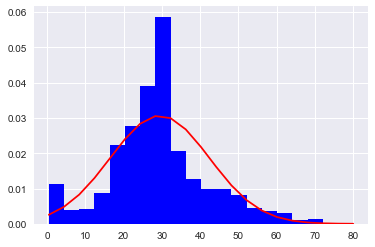

In [126]:
# 对填充后的年龄做一下分布情况统计
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

#据上面的统计，年龄最小的是几个月，最大的是80谁，所以对直方图，设计如下20个区间
num_bins=20
describe = titanic_df.Age.describe()
segma = describe['std']
mu = describe['mean']
plt.close("all")
_, bins, _ = plt.hist(titanic_df.Age, normed=1, bins=num_bins, color="blue")
# 拟合一条正态曲线
line = mlab.normpdf(bins, mu, segma)
plt.plot(bins, line, "red")
plt.show()

从直方图并结合当时的历史环境来看，填充还是比较符合预期
- 20-30岁的青壮、中年占比较多，这部分年龄阶层比较适合长途旅行、商务出行
- 符合当时社会年龄层次分布

## 年龄分段处理
把年龄分成9组：
- 小于10岁，A组
- 10-20岁，B组
- 20-30岁，C组
- 30-40岁，D组
- 40-50岁，E组
- 50-60岁，F组
- 60-70岁，G组
- 70-80岁，H组
- 大于80岁,G组

In [127]:
bins = np.arange(0, 90, 10)
titanic_df["Age_group"] = pd.cut(titanic_df.Age, bins)
titanic_df.groupby("Age_group")["PassengerId"].count()

Age_group
(0, 10]      64
(10, 20]    115
(20, 30]    407
(30, 40]    155
(40, 50]     86
(50, 60]     42
(60, 70]     17
(70, 80]      5
Name: PassengerId, dtype: int64

## 对乘客是否结伴而行进行分组

In [128]:
def transform_sp(val):
    if val > 0:
        return 'Y'#结伴而行的
    else:
        return 'N'#没有结伴而行的
    
titanic_df["sp_type"] = titanic_df.SibSp.add(titanic_df.Parch).apply(transform_sp)

----
# 数据分析

## 统计从不同港口登船的人数占比

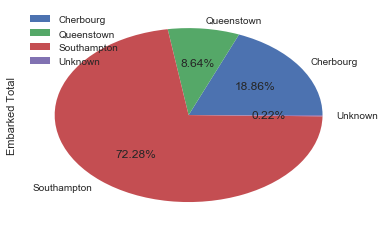

In [129]:
sns.set(color_codes=True)
plt.close('all')
embarked_total = titanic_df.groupby('Embarked').count()
# 生成饼图
labels = ['Cherbourg', 'Queenstown', 'Southampton', 'Unknown']
embarked_total.plot.pie(y='PassengerId', labels=labels, autopct='%1.2f%%')
plt.ylabel('Embarked Total')
plt.show()

<pre>从上图说得，很多旅客是从Southampton登船，其次是Cherbourg，再次是Queenstown，还有两位旅客未知
也因为Southampton是泰坦尼克号的启航地，所以登船人数最多
<pre>

In [130]:
# 多索引统计
def multi_index_groupby_count(index_names, g_as_index=False, ret_cols_names=None):
    if ret_cols_names is not None:
        return titanic_df.groupby(index_names, as_index=g_as_index).count()[ret_cols_names]
    else:
        return titanic_df.groupby(index_names, as_index=g_as_index).count()

# 根据索引某个值，获取行
def get_index_byvalue(df, index_name, by_val, ret_cols_names=None):
    if ret_cols_names is not None:
        return df.loc[df[index_name] == by_val][ret_cols_names]
    else:
        return df.loc[df[index_name] == by_val]
    
def indexs_group_by(index_names, g_as_index=True, ret_cols_names=None):
    if ret_cols_names is not None:
        return titanic_df.groupby(index_names, as_index=g_as_index)[ret_cols_names]
    else:
        return titanic_df.groupby(index_names, as_index=g_as_index)

## 问题1: 仓位等级是否和幸存相关？

In [131]:
def div_by_cols_val(df, cols_name, map_df, map_cols_name):
    return df[cols_name].div(df[map_cols_name].map(map_df.set_index(map_cols_name)[cols_name]))

def not_survived_cal(val):
    return 1 - val

surviveds = titanic_df.groupby("Pclass").Survived.mean()
not_surviveds = surviveds.apply(not_survived_cal)

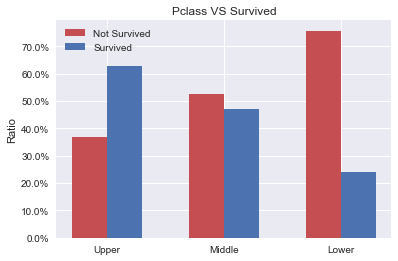

In [132]:
# 绘制比例图形对比结果
from matplotlib.ticker import FuncFormatter

plt.close("all")
def to_percent(y, position):
    return str(100 * y) + '%'

formatter = FuncFormatter(to_percent)

def create_bar_plot(df1, df2, xlabels=None, ylabel=None, bar_width=0.3, legend_names=None, title=None):
    arange = np.arange(df1.count())
    p1 = plt.bar(arange, df1, bar_width, color="r")
    p2 = plt.bar(arange+bar_width, df2, bar_width, color="b")
    x_labels = xlabels
    plt.xticks(arange + bar_width/2, x_labels)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend((p1[0], p2[0]), legend_names)
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.show()

x_labels = ["Upper", "Middle", "Lower"]

create_bar_plot(not_surviveds, surviveds, x_labels, "Ratio", legend_names=("Not Survived", "Survived"), title="Pclass VS Survived")

从上图可以看出：
- 生还率在阶级层面来看非常分明
- 越是头等舱的乘客越优先获救，头等舱的乘客接近63%被救出
- 3等仓虽然人数众多，但是也接近76%的人没有获救。

## 幸存和性别是否相关？

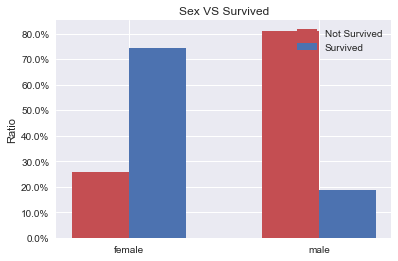

In [133]:
sex_total = indexs_group_by("Sex", ret_cols_names="Survived")
sex_surviveds = sex_total.mean()
sex_not_surviveds = sex_surviveds.apply(not_survived_cal)
# 画图
x_labels = ["female", "male"]
legend_names=("Not Survived", "Survived")
create_bar_plot(sex_not_surviveds, sex_surviveds, xlabels=x_labels, ylabel="Ratio", legend_names=legend_names, title="Sex VS Survived")

女性的幸存比例是男性的3倍有多，可以看出当时欧洲的绅士风度在危难时候依然起作用，大部分女性乘客都优先登上救生艇离开了。

## 年龄和幸存是否相关?

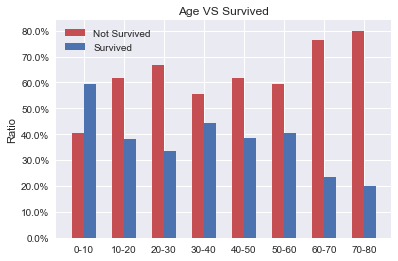

In [134]:
age_group_total = indexs_group_by("Age_group", ret_cols_names="Survived")
age_group_surviveds = age_group_total.mean()
age_group_not_surviveds = age_group_surviveds.apply(not_survived_cal)

# x轴标签
x_labels=["0-10", "10-20", "20-30", "30-40", "40-50", "50-60", "60-70", "70-80"]
cols_name = "survived_ratio"
ylabel="Ratio"
legend_names=("Not Survived", "Survived")
create_bar_plot(age_group_not_surviveds, age_group_surviveds, \
                x_labels, ylabel=ylabel, legend_names=legend_names, title="Age VS Survived")

从幸存率来看，年龄越小，幸存率越高（蓝色部分）。

但是0-10岁的死亡率相对于自身来说，还是有点高，从上面的统计可以看出，大概有26名儿童是没有被救的。

## 为什么0-10岁这个人群，有40%没有幸存下来？

In [135]:
s_age_group2 = multi_index_groupby_count(['Survived', 'Age_group', 'Pclass'], False, ['Survived', 'Age_group', 'Pclass', 'PassengerId'])
ns_a = s_age_group2.loc[s_age_group2["Survived"] == 0]
ns_a.loc[ns_a['Age_group'] == pd.Interval(left=0, right=10)]

,Survived,Age_group,Pclass,PassengerId
0,0,"(0, 10]",1,1.0
1,0,"(0, 10]",2,NaN
2,0,"(0, 10]",3,25.0


不幸罹难的儿童中，有25名来自lower仓位。想不到在危难面前，仓位等级差别，贫富差别也会体现到儿童身上。

## 幸存是否和结伴而行有关？

sp_type
N    0.303538
Y    0.505650
Name: Survived, dtype: float64
sp_type
N    0.696462
Y    0.494350
Name: Survived, dtype: float64


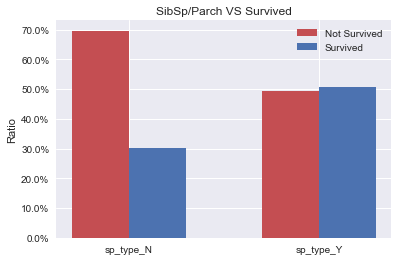

In [136]:
sp_total = indexs_group_by("sp_type", ret_cols_names="Survived")
sp_surviveds = sp_total.mean()
print(sp_surviveds)
sp_not_surviveds = sp_surviveds.apply(not_survived_cal)
print(sp_not_surviveds)
create_bar_plot(sp_not_surviveds, sp_surviveds, \
                xlabels=['sp_type_N', 'sp_type_Y'], ylabel='Ratio', legend_names=['Not Survived', 'Survived'], title="SibSp/Parch VS Survived")

- 蓝色都是有结伴而行的乘客
- 红色都是没有结伴而行的

可以从右侧的两条柱状图看出，结伴而行的乘客幸存率要高出将近一倍。这个说明出门在外，有个照应是很重要的。

---
# 数据分析总结

## 对分析数据进行总结

1. 很多旅客是从Southampton登船，其次是Cherbourg，再次是Queenstown，还有两位旅客未知。也因为Southampton是泰坦尼克号的启航地，所以登船人数最多
2. 幸存率和仓位等级相关，Pclass值为1的乘客，幸存率高达63%，而仓位最低级的乘客，幸存率仅有23%，两者相差3倍之多
3. 幸存率和性别相关，女性的幸存率高于男性，是男性的3倍
4. 年龄越小，幸存率越高，0-10岁的幸存率最高，按照年龄分段来看生还率(0-10]>(10-20]>(20-30]>(30-40]>(40-50]>(50-60]>(60-70]>(70-80]>(80-90]但有一点，0-10岁的这部分儿童，如果所处的Pclass为Lower的话，就没有那么幸运了。
5. 如果这次路途是结伴而行的话，幸存率会比单独出行的，稍微要高20%，这里证明出门在外有个照应是多么重要。

## 分析局限性

- 泰坦尼克号上的总人数是2224人，死亡人数是1514，生还人数是710人，本次抽样数据是891人。
- 如果本次分析样本是随机抽样无偏的话，根据中心极限定理，分析结果具有代表性，如果不是随机选出，那么分析结果就不可靠了。

[参考文献](https://zh.wikipedia.org/wiki/%E6%B3%B0%E5%9D%A6%E5%B0%BC%E5%85%8B%E5%8F%B7)